# Surfmi Package

This notebook demonstrates different applications of the surfmi-package. The Python package provides access to 
user-friendly functions to calculate and analyse Sentinel-1 (S1) relative surface moisture products at different spatio-temporal levels.

The package uses S1 data in VV polarisation pre-processed with the PyroSAR package $^1$ 
 and is therefore based on the naming 
convention used therein.

The functions are divided into three divisions. Functions within the envi_raster module 
perform raster operations, such as the calculation of percentiles, 
the moisture algorithm $^2$, and the temporal aggregation of the data.
Envi_mapping and envi_plotting provide functions for 
interactive data visualization with python's matplotlib and plotly.


# Installation

For Windows installations the use of Anaconda is recommended.
The package requires Python3 and gdal (`conda install -c conda-forge gdal`).


Surfmi is accessible via https://github.com/JhBongard/surfmi and can be installed using the anaconda prompt:
- `conda install git`
- `python -m pip install git+https://github.com/JhBongard/surfmi.git`




# Module 1: envi_raster

This module provides access to raster operations that are necessary for the caluclation
of S1 moisture products. 
In the first step the import function transfers the S1 data into an Python object of 
the EnviRaster class.
To calculate the moisture from an EnviRaster object, previously computed percentiles are required. 
The moisture product as well as the imported S1 backscatter data can be aggregated temporally.
All results and intermediate products are exportable.

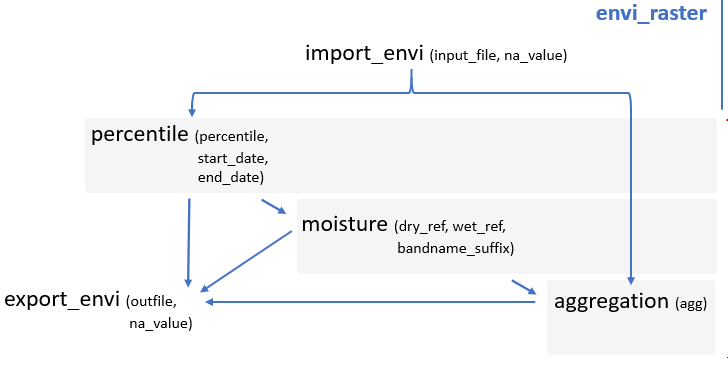

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image
Image("img/envi_raster.PNG",width=700, height=700)


## Import of S1 data

Only Sentinel-1 data in Envi format can be imported. The package adapts to the naming convention of the 
pyroSAR package mentioned above. 

The individual layers must meet the following naming convention:
- `S1B__IW___D_20190711T031747_VV_grd_mli_norm_geo_db`

Besides the pre-processed S1 data, all products of the EnviRaster package can be imported.
The naming convention for subsequent products is explained within the corresponding function:
- `S1A__IW___A_20150320T163021_VV_grd_mli_norm_geo_db_moist`
- `S1___IW_____VV_20150101_20151231_022_agg_Y`
- `S1___IW_____VV_20170101_20190101_136_per98`



**EnviRaster.import_envi(s1_file, na_value)**
- *s1_file* (File to Sentinel-1 Envi data)
- *na_value* (No data value)

In [3]:
from surfmi.envi_raster import EnviRaster
s1_file = "data/S1_VV"

s1 = EnviRaster.import_envi(input_file = s1_file, na_value = -99)

## EnviRaster Class

The Envi Raster class simplifies the handling of raster data within Python. 
The class contains four instances:
- *header* (time series dataframe containing information about date, layernames and array_id)
- *ndarray* (containing the raster data as numpy ndarrays)
- *trans* (information about the georeference)
- *proj* (information about the projection)

In [4]:
s1.header[0:5]

,layernames,date,array_id
date,,,
2016-01-02,S1A__IW___A_20160102T163016_VV_grd_mli_norm_ge...,2016-01-02,0
2016-01-14,S1A__IW___A_20160114T163015_VV_grd_mli_norm_ge...,2016-01-14,1
2016-01-26,S1A__IW___A_20160126T163015_VV_grd_mli_norm_ge...,2016-01-26,2
2016-02-07,S1A__IW___A_20160207T163015_VV_grd_mli_norm_ge...,2016-02-07,3
2016-03-02,S1A__IW___A_20160302T163015_VV_grd_mli_norm_ge...,2016-03-02,4


In [5]:
s1.ndarray.shape

(109, 277, 205)

In [6]:
s1.trans

(387495.915527344, 10.0, -0.0, 7209562.30108643, -0.0, -10.0)

In [7]:
s1.proj

'PROJCS["WGS_1984_UTM_Zone_36S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",33],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

In order to make it easier to extract information from the header, some getter-functions are available:
- *get_name_fnr(self, array_id)*
- *get_nr_fdate(self, date)*
- *get_nr_fname(self, layername)*

In addition some getter functions extract individual arrays from the ndarray based on their layername or array_id:
- *get_array_fname(self, layer)*
- *get_array_fnr(self, array_id)*


In [8]:
layer = s1.get_name_fnr(204)
print(layer)
number = s1.get_nr_fname("S1B__IW___D_20190711T031747_VV_grd_mli_norm_geo_db")
print(number)

S1B__IW___D_20190711T031747_VV_grd_mli_norm_geo_db
204


In [9]:
array = s1.get_array_fname("S1B__IW___D_20190711T031747_VV_grd_mli_norm_geo_db")
print(array.shape)

(109, 277)


## Calculation of percentiles 
The function calculates percentiles within a defined period of time. 
For the calibration of the moisture product, two percentiles are required.  
The function returns an array as EnviRaster object. Its band name 
is composed of the following information:
    
`S1___IW_____VV_2017-01-01_2019-01-01_136_per95`

- `2017-01-01` start date
- `2019-01-01` end date
- `136` number of scenes on which the calculation is based
- `95` the used percentile


**percentile(percentile, start_date, end_date)**
- *percentile* (between 0-100)
- *start_date* (in "YYYY-mm-dd" format)
- *end_date* (in "YYYY-mm-dd" format)

In [4]:
p_lower = EnviRaster.percentile(s1, percentile=5, start_date="2017-01-01", end_date="2018-12-31")
p_upper = EnviRaster.percentile(s1, percentile=95, start_date="2017-01-01", end_date="2018-12-31")

print(p_lower.header.layernames)
print(p_upper.header.layernames)

0    S1___IW_____VV_20170101_20181231_136_per5
Name: layernames, dtype: object
0    S1___IW_____VV_20170101_20181231_136_per95
Name: layernames, dtype: object


## Computation of S1-moisture


The function calculates the relative surface moisture $^2$. 
It is expected that short time variations in the VV backscatter are directly related to surface moisture variations. 
The relative surface moisture is calculated by using a dry- and wet-reference:
    
SurfMI = ((S1_layer - dry_reference) / (wet_reference - dry_reference))*100 

To reduce the influence of speckle, the 5th and 95th percentile are used here as dry- and wet-reference.
Values above or below the two references are set to 0 and 100% so that the value range is preserved.

The layernames are taken from the input S1 data and any suffix can be appended: 
- `S1B__IW___D_20190711T031747_VV_grd_mli_norm_geo_db_moist`


**moisture(dry_ref, wet_ref, layername_suffix)**
- *dry_ref* (lower percentile)
- *wet_ref* (upper pecentile)
- *layername_suffix* (string to indicate the moisture product)



In [5]:
s1_moist = EnviRaster.moisture(s1, dry_ref=p_lower, wet_ref=p_upper, layername_suffix="_moist" )
print(s1_moist.header.layernames[0])

S1A__IW___A_20160102T163016_VV_grd_mli_norm_geo_db_moist


## Temporal aggregation

The function uses the EnviRaster header, which is a pandas time series dataframe. 
Therefore the pandas resample function is used to aggregate the data temporally.
As aggregation steps the options "M" (monthly), "Q" (quarterly), "Y"(yearly) are available.
Within each time interval, the median is calculated.
The function returns an EnviRaster object. Its band names are composed of:

`S1___IW_____VV_2015-01-01_2015-12-31_022_agg_Y`

- `2015-01-01` start date
- `2015-12-31` end date
- `022` number of scenes on which the aggregation is based on
- `Y` indicating the used aggregation option


**aggregation(agg)**
- *agg* (aggregationa option: "M", "Q", "Y")


In [6]:
s1_moist_y = EnviRaster.aggregation(s1_moist, "Y")

print(s1_moist_y.header.layernames)

0    S1___IW_____VV_20160101_20161231_030_agg_Y
1    S1___IW_____VV_20170101_20171231_064_agg_Y
2    S1___IW_____VV_20180101_20181231_072_agg_Y
3    S1___IW_____VV_20190101_20191231_039_agg_Y
Name: layernames, dtype: object


## Export data

This function exports an object of class EnviRaster as Envi file.

**EnviRaster.export_envi(outfile, na_value)**
- *outfile* (Output filename)
- *na_value* (No data value)

In [7]:
EnviRaster.export_envi(s1_moist,"data/s1_moist",-99)

Exported!


# Module 2: envi_mapping

Each EnviRaster object can be displayed as a map. RGB images can be displayed 
as well as single layers using greyscale.


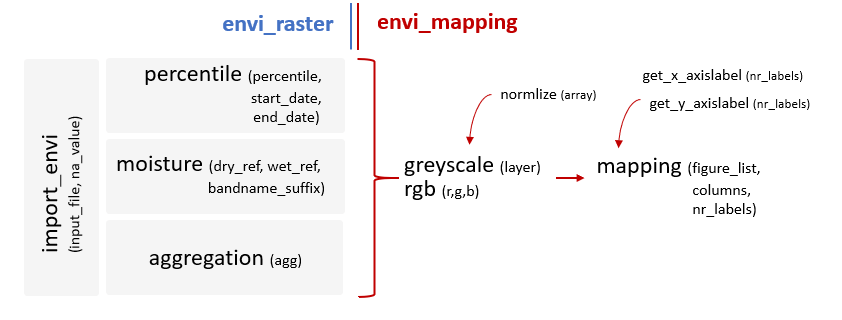

In [9]:
Image("img/envi_mapping.PNG",width=700, height=700)

## Greyscale & RGB

To select one or more layers for the map, the array_id has to be specified within the 
greyscale() and rgb() function.
Using the implemented normalize() function, the values of the selected arrays are scaled to the 
2nd and 98th percentile and normalized between 0 and 1.
As map scale, the pixel coordinates are extracted from the EnviRaster using the built-in axislabel() functions.


**greyscale(sef,layer)**
- *self* (EnviRaster object)
- *layer* (defining the layer selection)

**rgb(self,r,g,b)**
- *self* (EnviRaster object)
- *r* (defining the layer selection for the red channel)
- *g* (defining the layer selection for the green channel)
- *b* (defining the layer selection for the blue channel)

In [11]:
from surfmi.envi_mapping import *

image = greyscale(s1,1)
print(image.ndarray.shape)

image = rgb(s1,0,1,2)
print(image.ndarray.shape)

(109, 277)
(109, 277, 3)


## Mapping

This function creates an interactive map product (with zooming & panning) with any number of rgb
and greyscale EnviRasters, as long as the same spatial coverage and coordiante system is used.

The map appears in a separate matplotlib window. The arrangement of the individual submaps can be 
adjusted for each window size under "Configure Subplots" --> "Tight Layout".


**mapping(figure_list, columns, nr_labels)**
- *figure_list* (list containing rgb() / greyscale() EnviRaster objects)
- *columns* (specifies the number of rows in the layout)
- *nr_labels* (specifies the amount of x & y- axis labels)

In [12]:
%matplotlib qt 
mapping(figure_list=[rgb(s1,0,1,2),
                     greyscale(s1,0),
                     rgb(s1_moist_y,0,1,2),
                     greyscale(s1_moist_y,0)],
        columns=2,
        nr_labels = 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


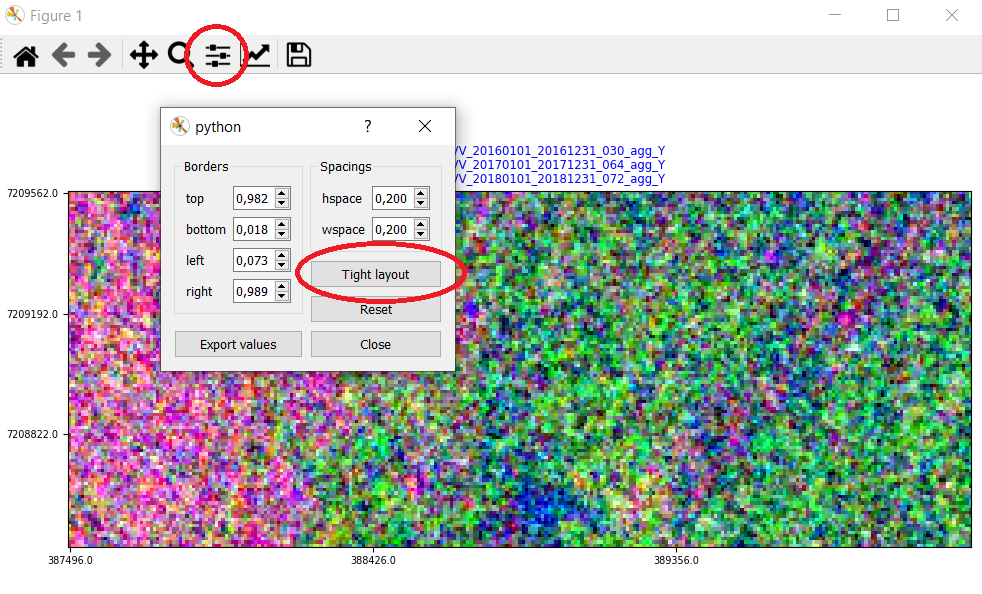

In [28]:
Image("img/mapping.PNG", width=700, height=700 )

# Modul 3: envi_plotting

This module provides functions for the interactive representation of the relative surface moisture.
In the first step, the median and standard deviation are extracted from the moisture 
EnviRaster on the basis of a shapefile. Finally the relative surface moisture can be plotted togehter with 
precipitation and soil moisture data. To better compare the temporal dynamics,
the S1 relative surface moisture can be smoothed to different degrees.



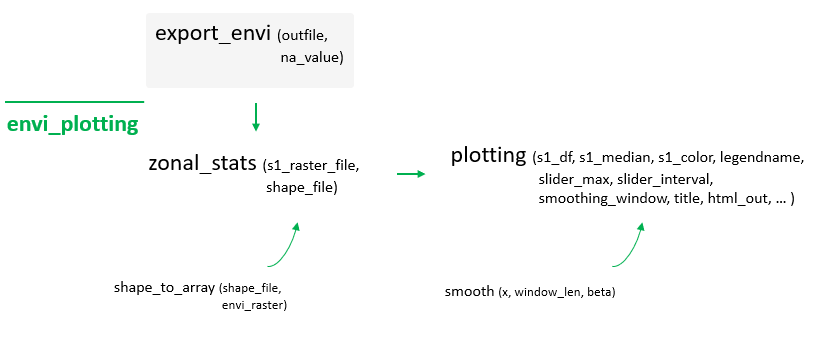

In [12]:
Image("img/envi_plotting.PNG",width=700, height=700)

## Extract zonal statistics

A shapefile predefines areas for which the median and standard deviation of an EnviRaster are obtained 
as a time series.
In the background, the shape_to_array() function is used to convert the shapefile into a numpy array. 
The values of the array corresponds to the IDs of the shapefile. 
For each ID the EnviRaster is masked, the two statistics are calculated and an entire dataframe is returned. 


**zonal_stats(s1_raster_file, shape_file)**
- *s1_raster_file* ()
- *shape_file* () 




In [17]:
from surfmi.envi_plotting import *

moist_df = zonal_stats("data/s1_moist","data/AOIs.shp")
print(moist_df[:1])

                                                   layernames       date  \
date                                                                       
2016-01-02  S1A__IW___A_20160102T163016_VV_grd_mli_norm_ge... 2016-01-02   

              median1      std1    median2       std2  
date                                                   
2016-01-02  57.759071  4.894762  21.072485  15.531023  


## Plotting

The relative surface moisture can now be plotted. The median identifiers ("median1", "median2", ...) 
that are based on the shapefile IDs can be labeled with the name of the associated land cover or area.

Optionally, precipitation data and soil moisture can be added
to the plot with separate axes.

Since the dynamics of surface moisture usually do not show a clear trend, 
there are two ways to smooth the time series. On the one hand, smoothing can be achieved by using 
the temporally aggregated EnviRasters. On the other hand this can also be achieved by a convolution of the time 
series.

This is done using the implemented smoothing function. The time series is smoothed by combining it with another signal. 
The combination results in a third smoothed signal.
This convolution is calculated from the weighted sum within a predefined window length. 
The window function is based on numpy kaiser windows which allows different beta parameters 
to influence the weighting and thus the smoothing. 
The interactive plot allows the control of the beta value, while the window length must be set in advance.



**envi_plotting (...)**
- *s1_df* (zonal_stats dataframe) 
- *s1_median (list containing a selection of median columns)
- *s1_color* (list which contains the coloring)
- *legendname* (list containing the legend names)


- *slider_max* (maximum of the beta value)
- *slider_interval* (interval value)
- *smoothing_window* (smoothing window length)


- *title* (plot title)
- *html_out* (storage file for the html)


- *precipitation_df* (optional: precipitation dataframe)
- *precipitation_selec* (optional: selection of precipitation columns)
- *precipitation_col* (optional: precipitation coloring)


- *soil_moisture_df* (optional: soil moisture dataframe)
- *soil_moisture_selec* (optional: selection of soil moisture columns)
- *soil_moisture_col* (optional: soil moisture coloring)



In [20]:
# import precipitation data
p_df = pd.DataFrame(pd.read_csv("data/precipitation.csv", sep=","))

# import soil moisture data
sm_df = pd.DataFrame(pd.read_csv("data/soilmoisture.csv", sep=","))

plotting(s1_df = moist_df,
         s1_median = ["median1","median2"],
         s1_color = ["0,139,0", "107,107,107"],
         legendname = ["Trees","Soil Moisture probe area small"],
                       
         slider_max = 250,
         slider_interval = 1,
         smoothing_window = 11,
                       
         precipitation_df=p_df,
         precipitation_selec=["Croc","Sabie"],
         precipitation_col=["0,191,255", "0, 0, 255"],
                       
         soil_moisture_df=sm_df,
         soil_moisture_selec=["h","a"],
         soil_moisture_col=["205,91,69", "255, 165, 0"],
                       
         title = "Smoothing S1",
         html_out = "data/S1_Moisture_Timeseries.html"
        )

## Smoothing Demo

In order to be able to better assess the settings of the smoothing, 
the module includes a demo function that allows a comparison between
smoothed and unsmoothed graphs.

**smoothing_demonstration (...)**
- *s1_df* (zonal_stats dataframe)
- *s1_median* (selecting one median column)
- *s1_std* (selecting one std column)


- *slider_max* (maximum of the beta value)
- *slider_interval* (interval value)
- *smoothing_window* (smoothing window length)


- *title* (plot title)
- *html_out* (storage file for the html)


In [21]:
smoothing_demonstration(s1_df = moist_df, 
                        s1_median = "median2",
                        s1_std = "std2",
                        
                        slider_max= 250, 
                        slider_interval = 1, 
                        smoothing_window = 11,
                        title = "Smoothing Demo",
                        html_out = "data/Demo_S1_Moisture_Timeseries.html")

# References

$^1$ https://github.com/johntruckenbrodt/pyroSAR

$^1$John Truckenbrodt; Felix Cremer; Ismail Baris; Jonas Eberle (2019): PYROSAR: A FRAMEWORK FOR LARGE-SCALE SAR 
SATELLITE DATA PROCESSING. In:. Big Data from Space. 
https://www.researchgate.net/profile/John_Truckenbrodt/publication/334258406_PYROSAR_A_FRAMEWORK_FOR_LARGE-SCALE_SAR_SATELLITE_DATA_PROCESSING/links/5d1f4071a6fdcc2462c1ff1b/PYROSAR-A-FRAMEWORK-FOR-LARGE-SCALE-SAR-SATELLITE-DATA-PROCESSING.pdf.

                
$^2$Urban, Marcel; Berger, Christian; Mudau, Tami; Heckel, Kai; Truckenbrodt, John; Onyango Odipo, Victor et al. (2018):
Surface Moisture and Vegetation Cover Analysis for Drought Monitoring in the Southern Kruger National Park 
Using Sentinel-1, Sentinel-2, and Landsat-8. In: Remote Sensing 10 (9), S. 1482. DOI: 10.3390/rs10091482.